In [1]:
import pylab as pl
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# TIME SERIES ANALYSIS

## Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## Data:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [2]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [3]:
#after reading the datacube you should see:
mta = np.load("MTA_Fare.npy")
mta = mta.astype(float)
mta.shape

(600, 23, 194)

In [4]:
# clean up the data
mta[mta==-1] = np.nan

In [5]:
# Sum up fare for all ride types
mta_allsum =np.nansum(mta, axis=0)
mta_allsum = pd.DataFrame(mta_allsum)
mta_allsum.shape

(23, 194)

In [6]:
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [7]:
date = pd.date_range(start='06/1/2010', end='02/22/2014', freq='W')

In [8]:
date = pd.date_range(start='05/21/2010', end='02/21/2014', freq='W')
date = date[2:]
date.shape

(194,)

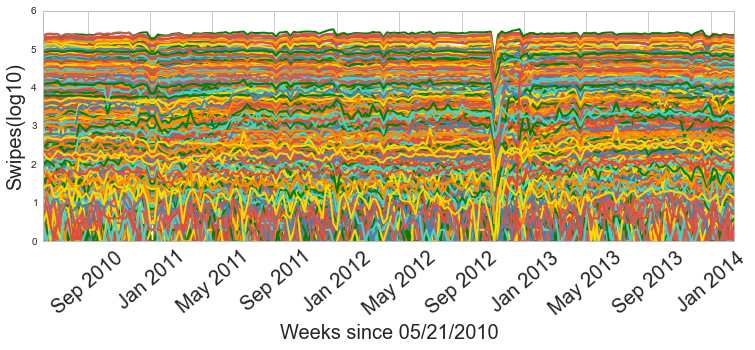

In [9]:
fig = figure(figsize=(12,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xlabel('Weeks since 05/21/2010', size=20)
ax.set_ylabel('Swipes(log10)', size=20)
ax.tick_params(axis='x',labelsize=10)
pl.xticks(rotation=40, fontsize=20)
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        ax.plot(date, np.log10(mta[i,j]))

## Task 1:
* Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
Identify it and figure out what it is due to.


In [10]:
# test the approach of threshold
thresholds = [mta_allsum.loc[0,:].mean() + 3*mta_allsum.loc[0,:].std(), 
              mta_allsum.loc[0,:].mean() - 3*mta_allsum.loc[0,:].std()]
print thresholds

[16889312.352366947, 9595433.5857773833]


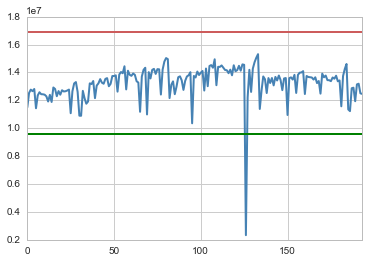

In [11]:
ax = mta_allsum.loc[0,:].plot()
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])

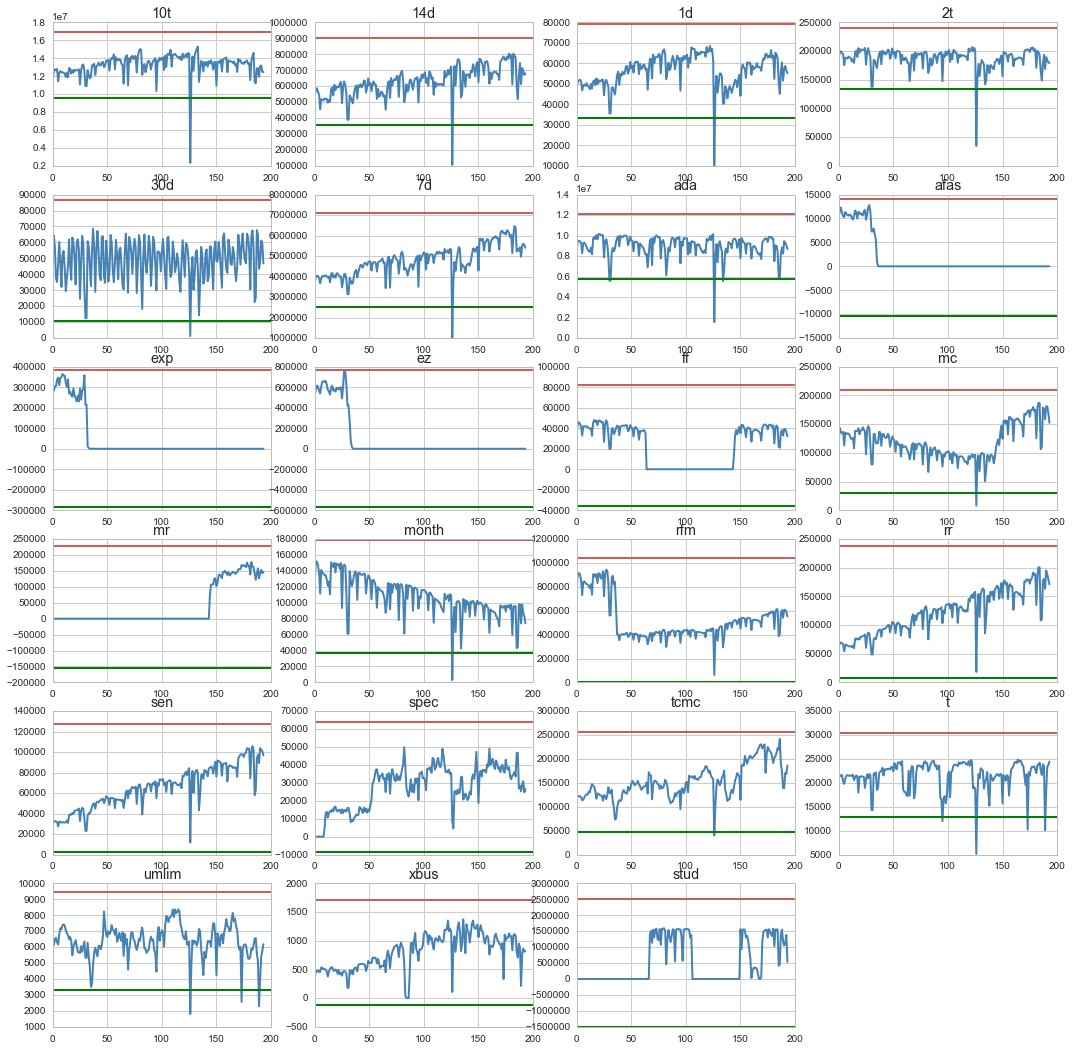

In [12]:
# Plot the week against total ride for all staion.
fig = plt.figure(figsize=(18,18))
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            ax.plot(mta_allsum.loc[i*4+j,:])
            thresholds = [mta_allsum.loc[i*4+j,:].mean() + 3*mta_allsum.loc[i*4+j,:].std(), 
                          mta_allsum.loc[i*4+j,:].mean() - 3*mta_allsum.loc[i*4+j,:].std()]
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])
            ax.set_title(ridetype[i*4+j])

In [13]:
# Event detection
events = pd.Series()
for i in range(23):
    thresholds = [mta_allsum.loc[i,:].mean() + 3*mta_allsum.loc[i,:].std(), 
                  mta_allsum.loc[i,:].mean() - 3*mta_allsum.loc[i,:].std()]
    # event = pd.concat([event, pd.Series(date[mta_allsum.index[mta_allsum.loc[i,:]<thresholds[1]]])], axis=0, ignore_index=True)
    event = (mta_allsum.loc[i,:]<thresholds[1])
    events = pd.concat([events, pd.Series(date[event.index[event==True]])], axis=0, ignore_index=True)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

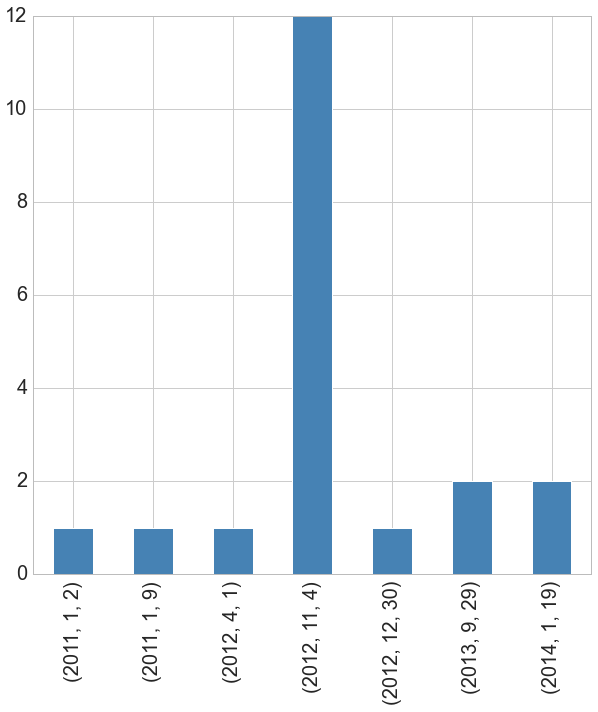

In [14]:
events.sort()
events.groupby([events.dt.year, events.dt.month, events.dt.day]).count().plot(kind="bar",fontsize=20, figsize=(10,10))
pl.xticks(rotation=90)

### My comment:

The sudden drop in MTA fare in November 4, 2012 should be caused by the Hurricane Sandy, which dated from October 22, 2012 to October 31, 2012.

## Task 2:
* Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

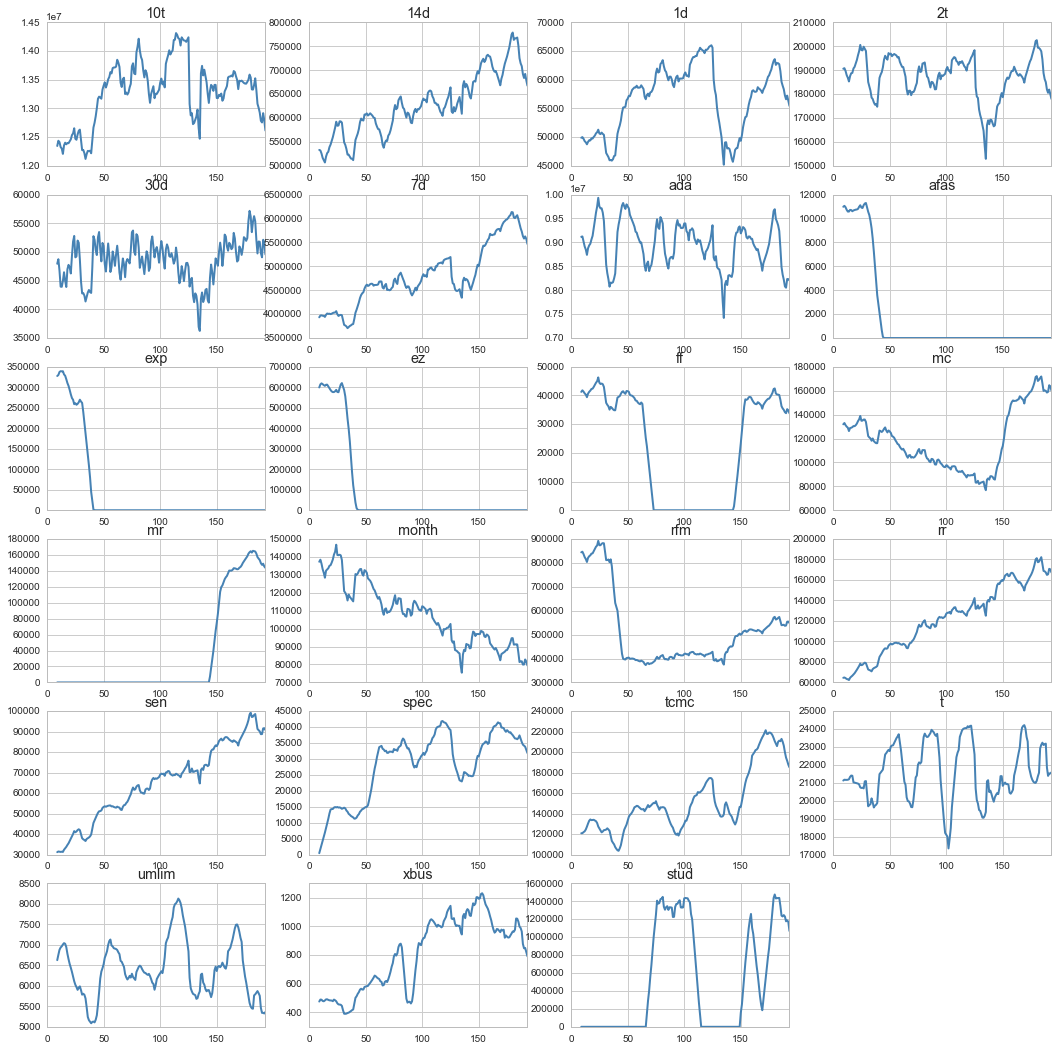

In [15]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
ratio = np.zeros(23)
std = np.zeros(23)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            roll_mean = pd.rolling_mean(mta_allsum.loc[i*4+j,:], 10)
            ax = roll_mean.plot()
            ratio[i*4+j] = roll_mean.loc[9]/roll_mean.loc[193]
            std[i*4+j] = np.nanstd(roll_mean)
            ax.set_title(ridetype[i*4+j])

In [16]:
from tabulate import tabulate
table = pd.DataFrame({'Type' : ridetype,
                     'Flux Ratio From Beginning to End' : ratio,
                     'Std' : std})
print tabulate(table, headers='keys', tablefmt="grid", floatfmt='.4f')

+---------+------------------------------------+-------------+--------+
|         |   Flux Ratio From Beginning to End |         Std | Type   |
+=========+====================================+=============+========+
|  0.0000 |                             0.9787 | 546777.6170 | 10t    |
+---------+------------------------------------+-------------+--------+
|  1.0000 |                             0.7987 |  64593.9014 | 14d    |
+---------+------------------------------------+-------------+--------+
|  2.0000 |                             0.8998 |   5767.4125 | 1d     |
+---------+------------------------------------+-------------+--------+
|  3.0000 |                             1.0709 |   8828.0039 | 2t     |
+---------+------------------------------------+-------------+--------+
|  4.0000 |                             0.9673 |   3624.0885 | 30d    |
+---------+------------------------------------+-------------+--------+
|  5.0000 |                             0.7196 | 631955.0178 | 7

### My comment:

Through using moving mean, we can see steady increase in ride type "14d" "7d" "ff" "sen"

And steady decrease in ride type "month", while "afas", "exp", "ez" had a steady decrease and a jump to zero

## Task 3:

Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


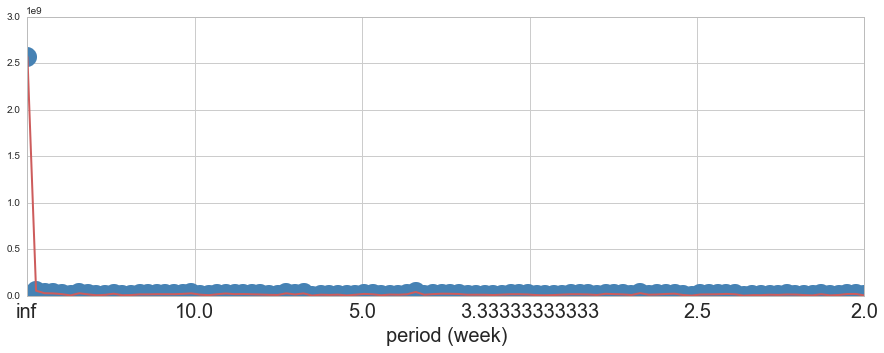

In [17]:
f = np.abs(np.fft.rfft(mta_allsum.loc[0,:]))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
sample_rate = 1
ax.plot(np.fft.rfftfreq(194, 1.0), (f), 'o', ms=20)
ax.plot(np.fft.rfftfreq(194, 1.0), (f), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)

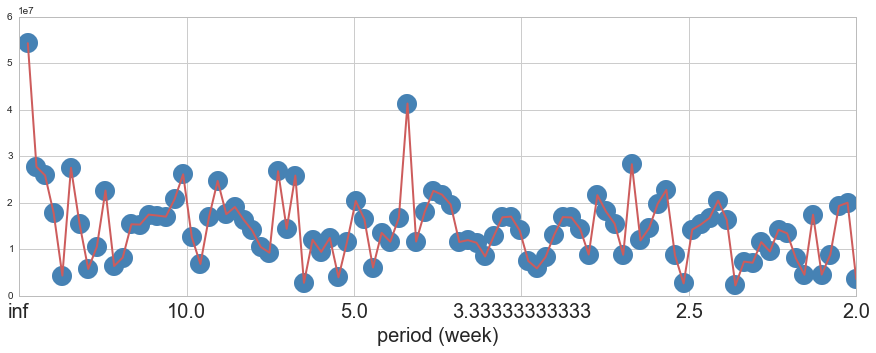

In [18]:
f = np.abs(np.fft.rfft(mta_allsum.loc[0,:]))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
sample_rate = 1
ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=20)
ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)

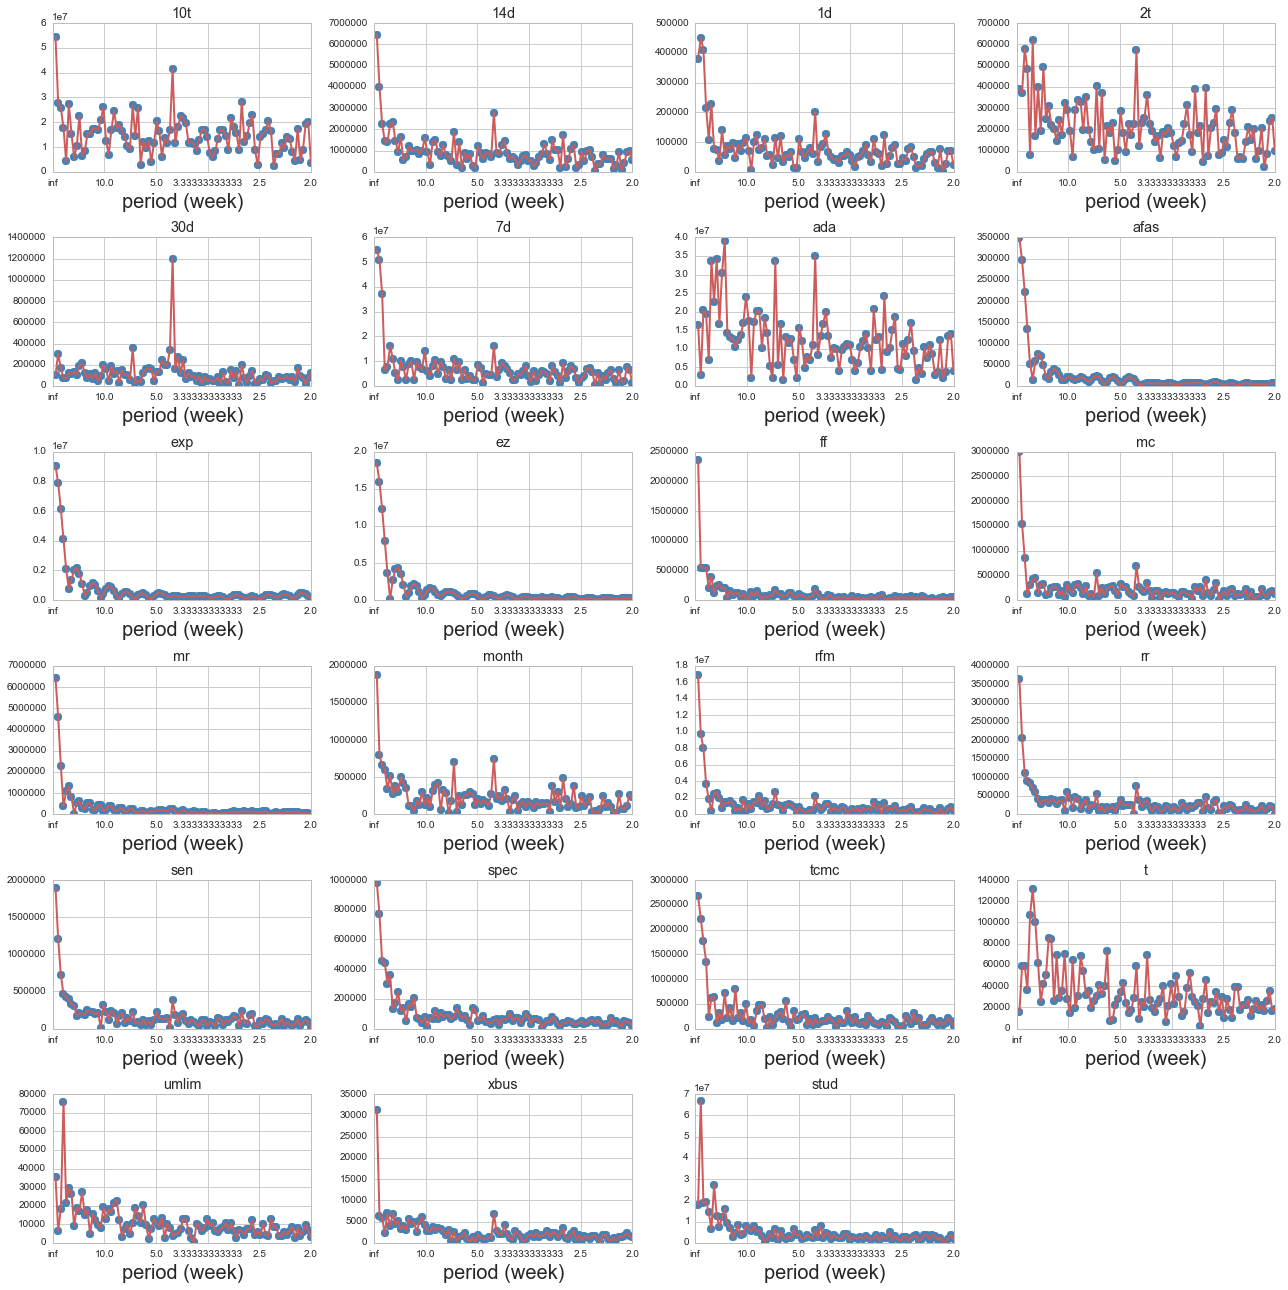

In [19]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
mta_allsum = pd.DataFrame(mta_allsum)
ratio = np.zeros(23)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            f = np.abs(np.fft.rfft(mta_allsum.loc[i*4+j,:]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
            ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10)
            pl.xlabel("period (week)", fontsize=20)
            ax.set_title(ridetype[i*4+j])
fig.tight_layout()

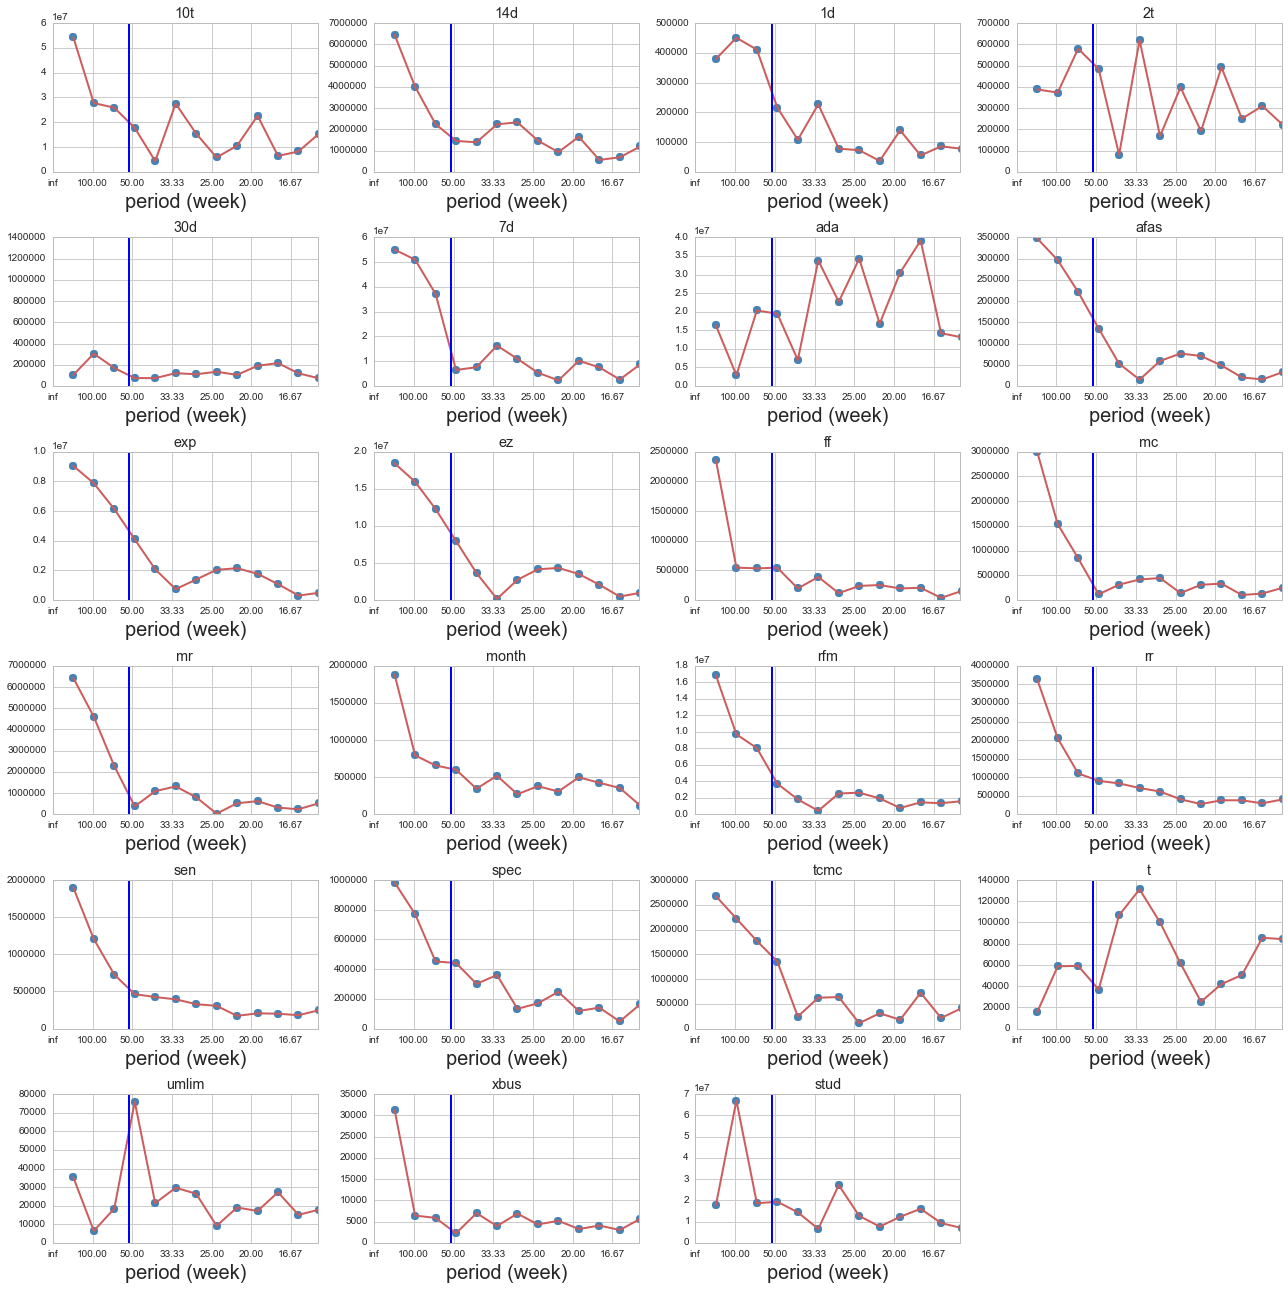

In [20]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
mta_allsum = pd.DataFrame(mta_allsum)
ratio = np.zeros(23)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            f = np.abs(np.fft.rfft(mta_allsum.loc[i*4+j,:]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
            ax.set_xlim(0,1.0/15)
            ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=10)
            pl.xlabel("period (week)", fontsize=20)
            plt.axvline(1.0/52)
            ax.set_title(ridetype[i*4+j])
fig.tight_layout()

### My comment:
From the Fourier Analysis, we can find "10t", "ada", "stud", they have almost the 2e+7 Power Spectrum.

"7d" has the 1.5e+7 Power Spectrum.

So the "10t", "ada", "stud", and "7d" have the most prominent annual periodicity.

### EXTRA CREDIT: Cluster.

Cluster the time series, i.e. identify groups of time series that look similar among each other. 

### My comment:

Doesn't sound like a good idea to use k-means on time series data. k-means is designed for low-dimensional spaces with a (meaningful) euclidean distance. It is not very robust towards outliers, as it puts squared weight on them. 

DWT distance is the way to go for time series

In [28]:
from sklearn import cluster, covariance, manifold

In [33]:
tots = mta.transpose(2,0,1).reshape(mta.shape[2], mta.shape[1]*mta.shape[0]).T
tots = tots[tots.std(1)>0]
X = tots.copy()
X /= X.std(axis=0)

In [35]:
_, labels = cluster(X)

TypeError: 'module' object is not callable